<a href="https://colab.research.google.com/github/Kryptera-K/BALL-Bollinger-Band-Expansion-with-ADX-Decay-Strategy/blob/main/BALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BALL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BALL_clean.csv", index=False)
df

/tmp/ipython-input-2407722376.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,1.921715,1.933783,1.879480,1.894564,3273600
2000-01-04,1.858362,1.945850,1.855346,1.909648,2446400
2000-01-05,1.891549,1.912666,1.852330,1.852330,1164800
2000-01-06,1.921715,1.954900,1.897581,1.897581,1073600
2000-01-07,1.867414,1.948868,1.852330,1.927750,2012800
...,...,...,...,...,...
2025-12-08,47.709999,48.910000,47.509998,48.910000,2184000
2025-12-09,46.869999,47.540001,46.849998,47.540001,1721800
2025-12-10,47.770000,48.299999,46.650002,46.779999,2770800


In [ ]:
ADX_LEVEL = 20
ADX_PERIOD = 14
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2

# -------------------------
# Indicator Functions
# -------------------------

def bb_expansion(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    """
    Detect Bollinger Band Expansion (bands widening)
    """
    df = calculate_bollinger_bands(df, period, std_multiplier)
    bandwidth = df['BB_Upper'] - df['BB_Lower']
    return bandwidth > bandwidth.shift(shift)


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df


def adx_cross_below_level(df, period=ADX_PERIOD, level=ADX_LEVEL):
    df = calculate_adx(df, period)
    return (df['ADX'].shift(1) >= level) & (df['ADX'] < level)


def calculate_adx(df, period=14):
    """
    Calculate ADX and related columns.
    """

    # True Range (TR)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # Directional Movement (DM)
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Smoothed values
    df['TRn'] = df['TR'].rolling(window=period).sum()
    df['+DMn'] = df['+DM'].rolling(window=period).sum()
    df['-DMn'] = df['-DM'].rolling(window=period).sum()

    # Calculate +DI and -DI
    df['+DI'] = 100 * (df['+DMn'] / df['TRn'])
    df['-DI'] = 100 * (df['-DMn'] / df['TRn'])

    # DX and ADX
    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df



# -------------------------
# Entry conditions
# -------------------------

df["BB_Expansion"] = bb_expansion(df)

# -------------------------
# Exit conditions
# -------------------------

df["ADX_XBelow20"] = adx_cross_below_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BB_Expansion',
]
exit_conditions = [
    'ADX_XBelow20',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-12-12 00:00:00
Period                                6527 days 00:00:00
Start Value                                     100000.0
End Value                                 3328050.409821
Total Return [%]                              3228.05041
Benchmark Return [%]                         2509.571246
Max Gross Exposure [%]                             100.0
Total Fees Paid                            265944.036159
Max Drawdown [%]                               50.825967
Max Drawdown Duration                 1279 days 00:00:00
Total Trades                                          79
Total Closed Trades                                   78
Total Open Trades                                      1
Open Trade PnL                             197151.868167
Win Rate [%]                                   62.820513
Best Trade [%]                                 42.977745
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-12 00:00:00
Period                         6527 days 00:00:00
Start Value                              100000.0
End Value                          2609571.245508
Total Return [%]                      2509.571246
Benchmark Return [%]                  2509.571246
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        55.300699
Max Drawdown Duration          1279 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     2509571.245508
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-4131579440.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


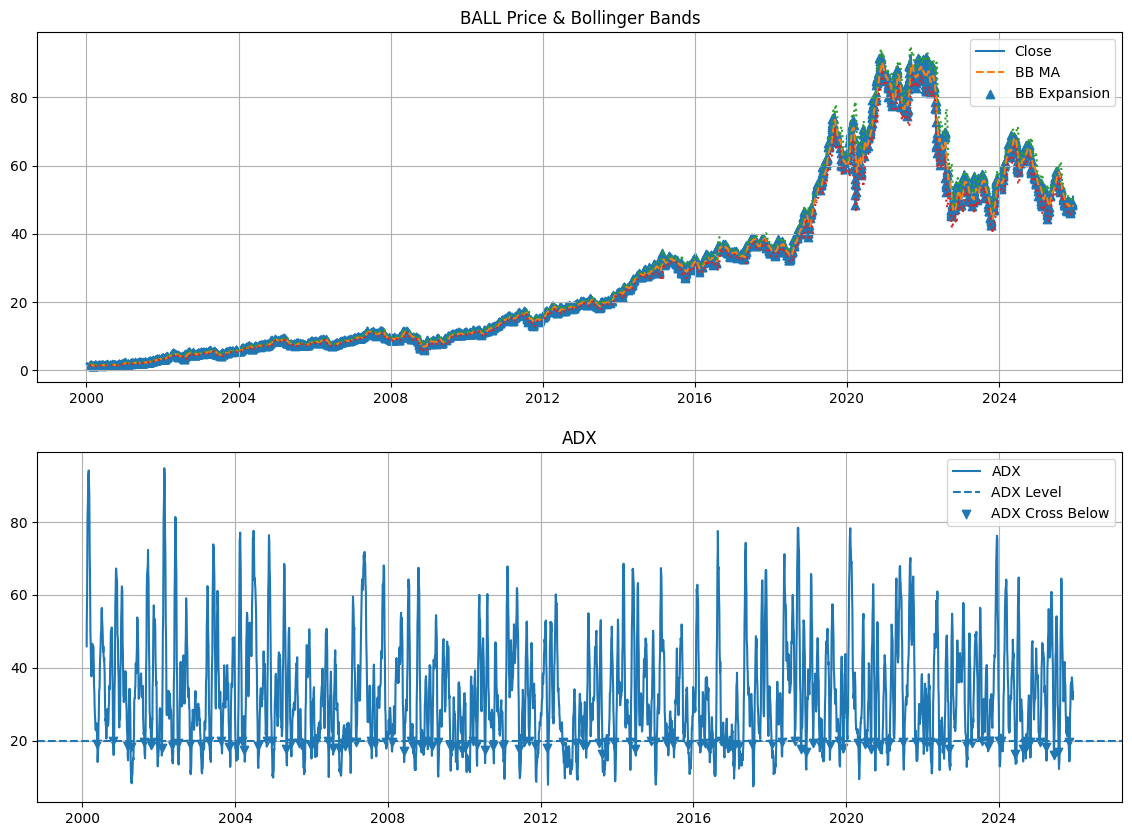

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "BALL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------
ADX_LEVEL = 20
ADX_PERIOD = 14
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2

# -------------------------
# Indicator Functions
# -------------------------
def calculate_bollinger_bands(df, period, std_multiplier):
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(period).std()
    return df

def bb_expansion(df, shift):
    bandwidth = df['BB_Upper'] - df['BB_Lower']
    return bandwidth > bandwidth.shift(shift)

def calculate_adx(df, period):
    df = df.copy()

    df['TR'] = np.maximum.reduce([
        df['High'] - df['Low'],
        abs(df['High'] - df['Close'].shift(1)),
        abs(df['Low'] - df['Close'].shift(1))
    ])

    df['+DM'] = np.where(
        (df['High'] - df['High'].shift(1)) >
        (df['Low'].shift(1) - df['Low']),
        np.maximum(df['High'] - df['High'].shift(1), 0),
        0
    )

    df['-DM'] = np.where(
        (df['Low'].shift(1) - df['Low']) >
        (df['High'] - df['High'].shift(1)),
        np.maximum(df['Low'].shift(1) - df['Low'], 0),
        0
    )

    df['TRn'] = df['TR'].rolling(period).sum()
    df['+DMn'] = df['+DM'].rolling(period).sum()
    df['-DMn'] = df['-DM'].rolling(period).sum()

    df['+DI'] = 100 * df['+DMn'] / df['TRn']
    df['-DI'] = 100 * df['-DMn'] / df['TRn']

    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(period).mean()

    return df

def adx_cross_below_level(df, level):
    return (df['ADX'].shift(1) >= level) & (df['ADX'] < level)

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_bollinger_bands(df, BB_PERIOD, BB_STD)
df = calculate_adx(df, ADX_PERIOD)

df['BB_Expansion'] = bb_expansion(df, BB_SHIFT)
df['ADX_Cross_Below'] = adx_cross_below_level(df, ADX_LEVEL)

# -------------------------
# Plotting
# -------------------------
plt.figure(figsize=(14, 10))

# === PRICE + BOLLINGER BANDS ===
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['BB_MA'], linestyle='--', label='BB MA')
plt.plot(df.index, df['BB_Upper'], linestyle=':')
plt.plot(df.index, df['BB_Lower'], linestyle=':')

plt.scatter(
    df.index[df['BB_Expansion']],
    df['Close'][df['BB_Expansion']],
    marker='^',
    label='BB Expansion'
)

plt.title(f"{symbol} Price & Bollinger Bands")
plt.legend()
plt.grid(True)

# === ADX + LEVEL ===
plt.subplot(2, 1, 2)
plt.plot(df.index, df['ADX'], label='ADX')
plt.axhline(ADX_LEVEL, linestyle='--', label='ADX Level')

plt.scatter(
    df.index[df['ADX_Cross_Below']],
    df['ADX'][df['ADX_Cross_Below']],
    marker='v',
    label='ADX Cross Below'
)

plt.title("ADX")
plt.legend()
plt.grid(True)

